In [1]:
from matplotlib import pyplot as plt
import networkx as nx
import random
import itertools
import scipy
import numpy as np
%matplotlib inline

In [6]:
class SocialDynamicsSimulation:
    '''
    Simulate social dynamics by strengthening opinions and connection weights
    based on random interactions between nodes.
    '''

    def __init__(self, network_size=50, alpha=0.01, beta=0.9, gamma=4, prob_new = 0.02, graph_type = 0):
        '''
        Inputs:

            network_size (int) The number of nodes in the network. Default: 50.

            alpha (float) The rate at which nodes adjust their opinions to
              match neighboring nodes' opinions during interactions.
              Default: 0.03.

            beta (float) The rate at which edge weights are changed in
              response to differing opinions. Default: 0.3.

            gamma (float) The pickiness of nodes. Nodes with opinions differing
              by more than 1/gamma will result in an edge weight decreasing.
              Default: 4.
              
            prob_new (float) The pobability of forming a new edge during each update.
            Default: 0.02
            
            graph_type (integer) The type of the graph used to build the network. If
            it equals 1, the model uses watts_strogatz_graph and erdos_renyi_graph 
            otherwise. Default: 1
        '''
        self.network_size = network_size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.prob_new = prob_new
        self.graph_type = graph_type
   
    def initialize(self):
        '''
        Initialize the simulation with a random graph. Initial edge weights are 0.5. 
        Each node has a set of three opinions which are randomly initialized to be 
        either 1 or 0. Opinions form the worldview and unequal importance with one
        opinion being the most formational. This opinion is defined by the "importance"
        attribute which is chosen randomly. Each node also has different level of 
        persuasiveness which is sampled from the normal distribution. 
        '''
        if self.graph_type == 1:
            self.graph = nx.watts_strogatz_graph(self.network_size, 5, 0.5)
        else:
            self.graph = nx.erdos_renyi_graph(self.network_size, 0.2)
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = np.random.uniform(0.3, 0.7)
        for node in self.graph.nodes:
            self.graph.nodes[node]['opinions'] = [float(random.randint(0, 1)) for i in range(3)]
            self.graph.nodes[node]['importance'] = random.randint(0,2)
            opinions = self.graph.nodes[node]['opinions']
            importance = self.graph.nodes[node]['importance']
            self.graph.nodes[node]['worldview'] = opinions[importance] * 0.8
            + 0.1 * opinions[(importance+1)%3] + 0.1 * opinions[(importance+2)%3]
            #print self.graph.nodes[node]['worldview']
            self.graph.nodes[node]['persuasiveness'] = np.random.normal(0.5, 0.3)
        self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0
        
    def observe(self):
        '''
        Draw the state of the network where the labels illustrate the worldview.
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        plt.clf()
        node_labels = {}
        for node in self.graph.nodes:
            n_label = float(self.graph.nodes[node]['worldview']*100)
            node_labels[node] = int(n_label)
        nx.draw(
            self.graph, pos=self.layout, with_labels=False,
            node_color=[self.graph.nodes[i]['worldview'] for i in self.graph.nodes],
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7, vmin=0, vmax=1)
        nx.draw_networkx_labels(self.graph, self.layout, node_labels)
        plt.title('Step: ' + str(self.step))
        
    def update(self):
        """
        Adds new connections according to the following rules:
        With a probability prob_new, find two nodes that are not connected.
        Check for the mutual connections. Nodes that have friends in common
        are more likely to meet, so they'll form a connection with a probability prob_new.
        The weight of the edge is determined as the average of all mutual connections.
        If these people don't have any mutual connections, the probability
        decreases to 0.1 * prob_new. The weight is chosen randomly from the uniform
        distribution in the range from 0.3 to 0.7
        
        Updates existing connections:
        Chooses two nodes and a topic randomly.
        Updates their opinions using the persuasiveness parameter.
        Updates the edge weight based on the new worldview.
        Removes week edges
        """
        if random.random() < self.prob_new:
            nodes = list(self.graph.nodes)
            while True:
                new_edge = random.sample(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            # Two nodes without an edge are identified, now we need to check for mutual connections.
            edges = []
            if len(list(nx.common_neighbors(self.graph, new_edge[0], new_edge[1]))) > 0:
                # In case there are mutual connections, we simply add the edge
                for mutual_node in list(nx.common_neighbors(self.graph, new_edge[0], new_edge[1])):
                    for node in [new_edge[0], new_edge[1]]:
                         edges.append(self.graph.edges[mutual_node, node]['weight'])
                #print edges
                weight = np.mean(edges)
                self.graph.add_edge(new_edge[0], new_edge[1], weight=weight)
            else:
                # Otherwise, the edge is formed with a probability 0.1
                if random.uniform(0, 1) < 0.5:
                    weight = np.random.uniform(0.3,0.7)
                    self.graph.add_edge(new_edge[0], new_edge[1], weight = weight)      
    
        else:
            # Select a random edge and update node opinions and edge weight
            edge = random.choice(list(self.graph.edges))
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n]['opinions'] for n in edge]
            for i in [0, 1]:
                topic = random.randint(0,2)
                new_opinion = self.alpha * weight * (opinions[1-i][topic] - opinions[i][topic])
                self.graph.nodes[edge[i]]['opinions'][topic] = opinions[i][topic] + new_opinion + self.graph.nodes[edge[1-i]]['persuasiveness'] *0.1*new_opinion
                opinion = self.graph.nodes[edge[i]]['opinions']
                imp = self.graph.nodes[edge[i]]['importance']
                self.graph.nodes[edge[i]]['worldview'] = opinion[imp] * 0.8 + 0.1 * opinion[(imp+1)%3] + 0.1 * opinion[(imp+2)%3]
            first_worldview = self.graph.nodes[edge[0]]['worldview']
            second_worldview = self.graph.nodes[edge[1]]['worldview']
            self.graph.edges[edge]['weight'] = (weight + self.beta * weight * (1-weight) * (1 - self.gamma * abs(first_worldview - second_worldview)))
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.remove_edge(*edge)
        self.step += 1

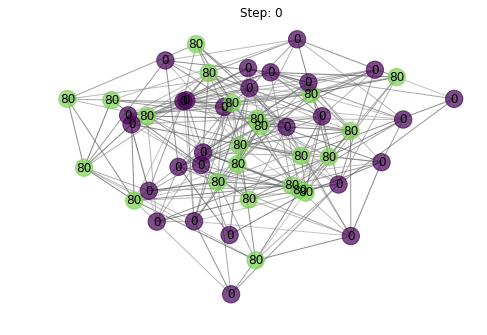

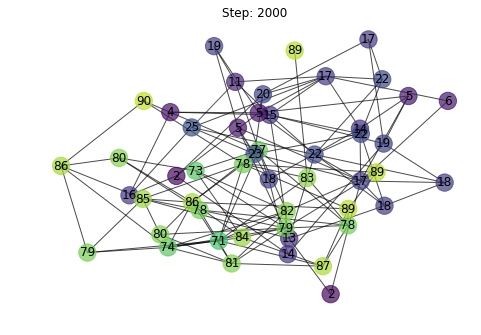

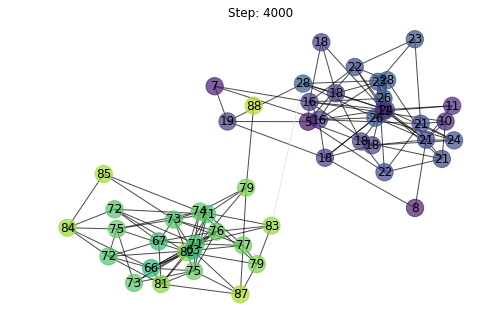

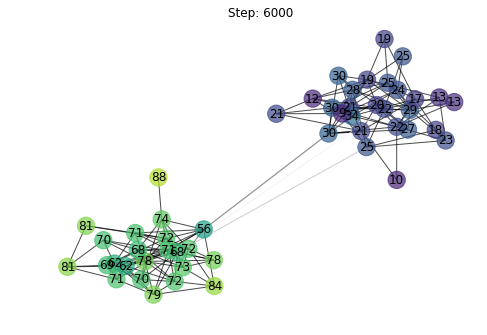

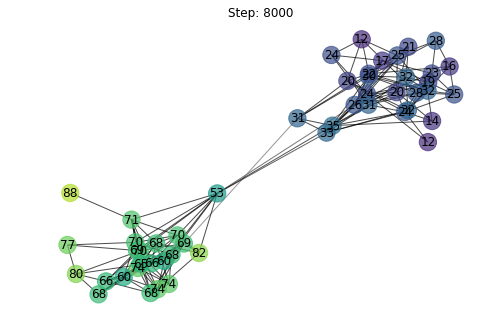

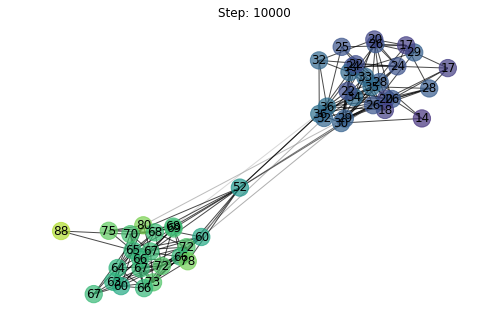

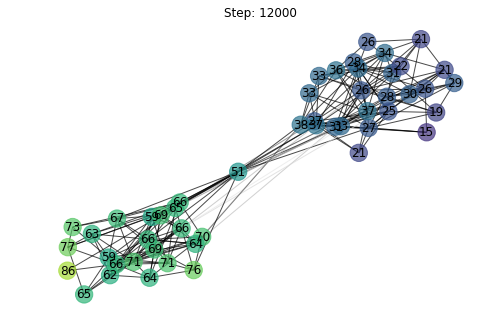

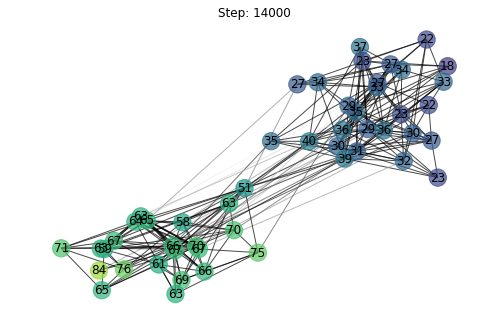

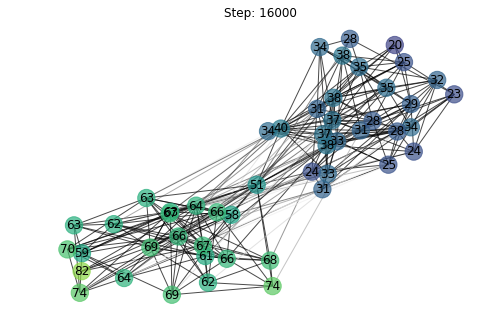

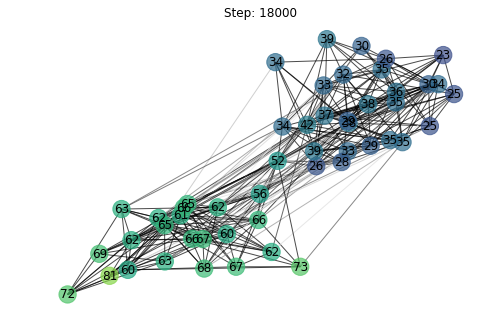

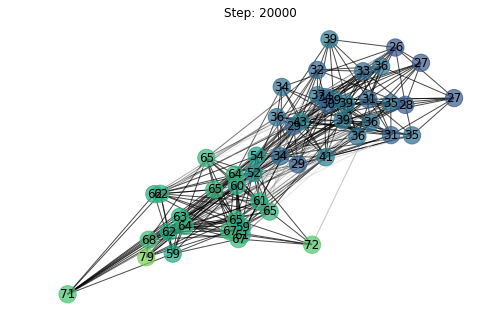

In [7]:
sim = SocialDynamicsSimulation()
sim.initialize()
plt.figure()
sim.observe()
for i in range(10):
    for i in range(2000):
        sim.update()
    plt.figure()
    sim.observe()
    plt.show()

In [8]:
alphas = [0.001,0.01, 0.03]
betas = [0.01,0.3, 0.99]
gammas = [0.5,4,8]
graph_types = [1,0]

0.001 1


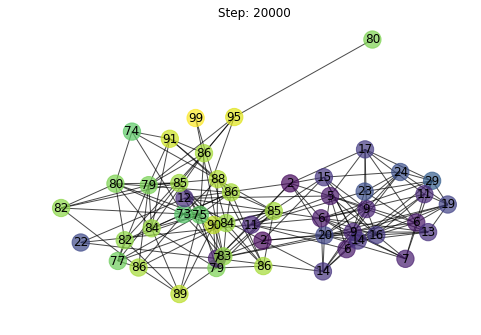

0.01 1


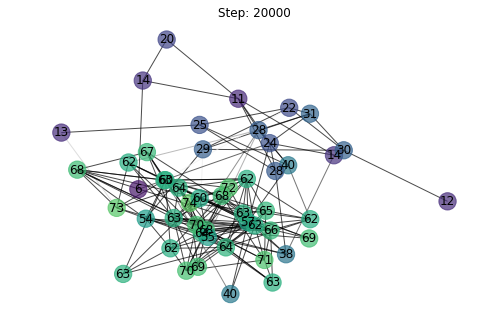

0.03 1


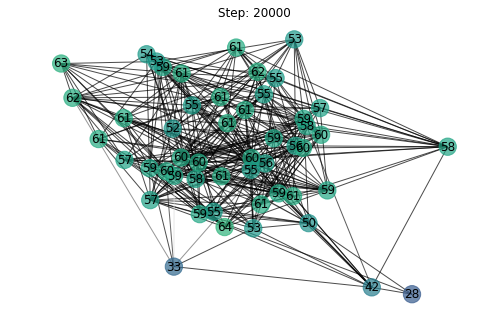

0.001 0


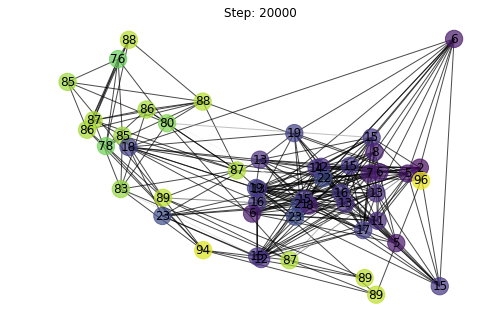

0.01 0


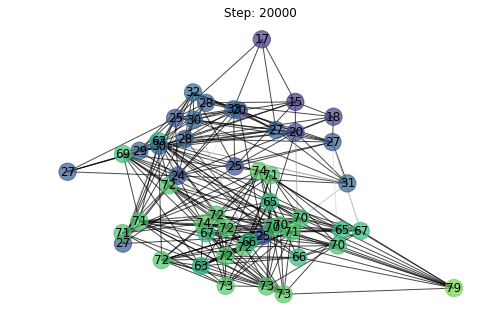

0.03 0


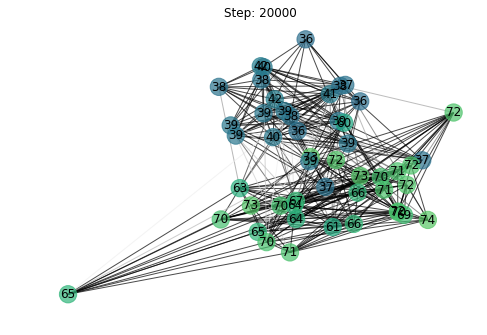

In [9]:
for graph_type in graph_types:
    for alpha in alphas:
        sim = SocialDynamicsSimulation(alpha=alpha, graph_type = graph_type)
        sim.initialize()
        for i in range(20000):
            sim.update()
        plt.figure()
        sim.observe()
        print alpha, graph_type
        plt.show()

0.01 1


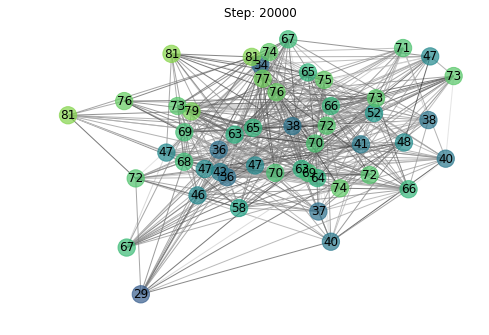

0.3 1


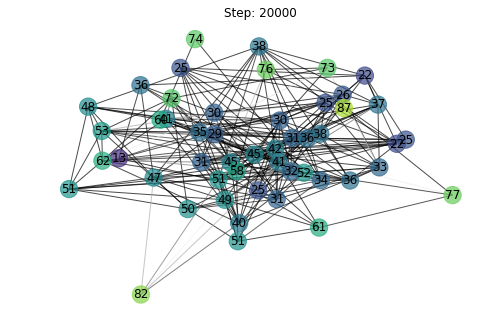

0.99 1


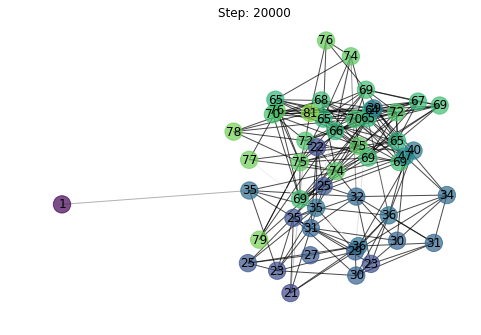

0.01 0


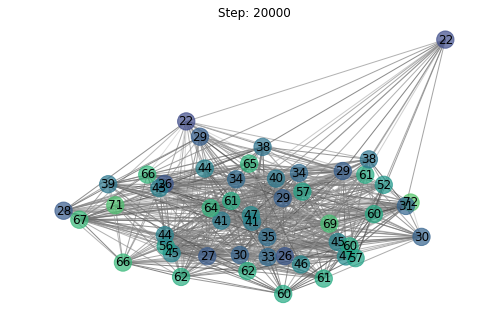

0.3 0


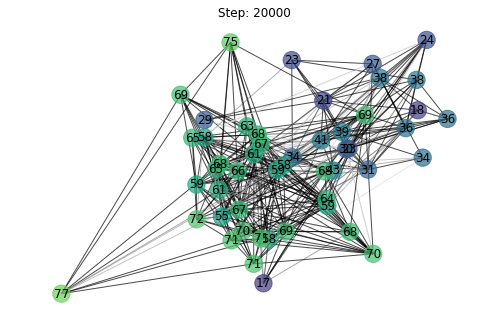

0.99 0


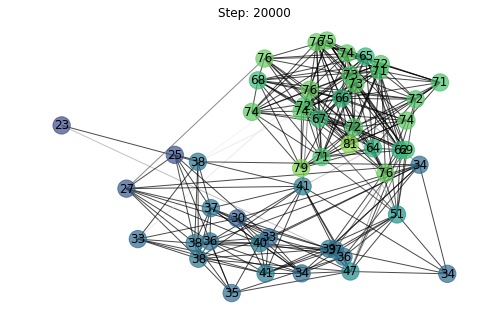

In [10]:
for graph_type in graph_types:
    for beta in betas:
        sim = SocialDynamicsSimulation(beta=beta, graph_type = graph_type)
        sim.initialize()
        for i in range(20000):
            sim.update()
        plt.figure()
        sim.observe()
        print beta, graph_type
        plt.show()

0.5 1


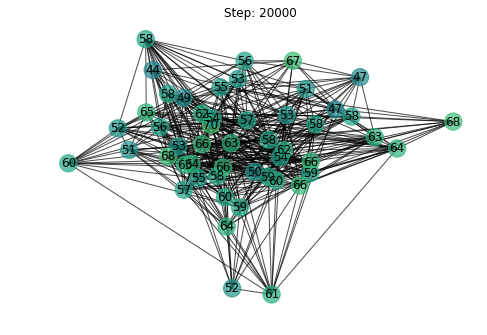

4 1


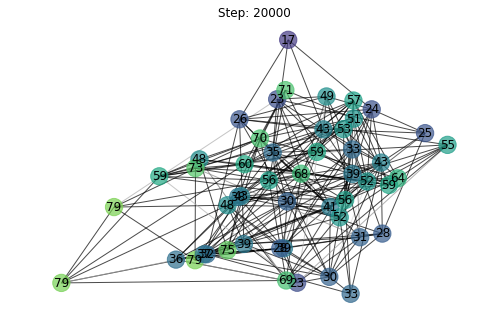

8 1


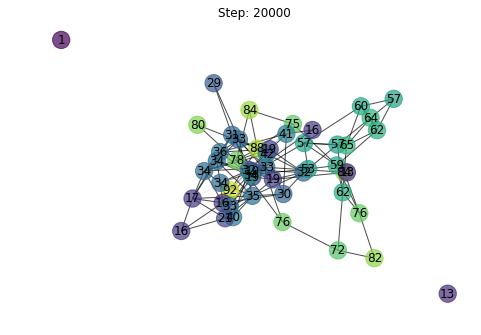

0.5 0


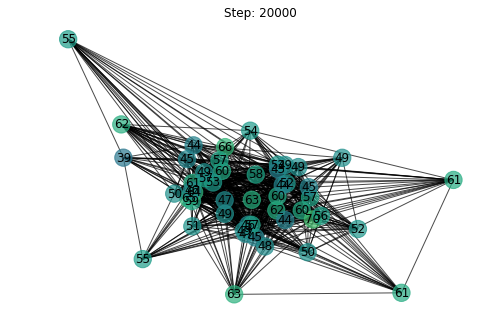

4 0


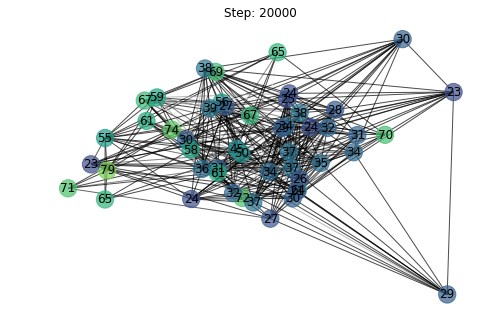

8 0


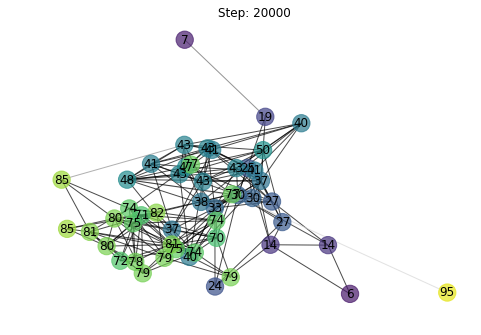

In [11]:
for graph_type in graph_types:
    for gamma in gammas:
        sim = SocialDynamicsSimulation(gamma=gamma, graph_type = graph_type)
        sim.initialize()
        for i in range(20000):
            sim.update()
        plt.figure()
        sim.observe()
        print gamma, graph_type
        plt.show()

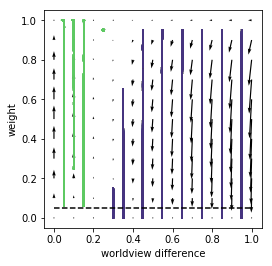

In [12]:
alpha = 0.01
beta = 0.3
gamma = 4

cmap = plt.cm.viridis  # color map to use

# Plot traces of how opinion and weight change over time
for worldview, weight in [
    [0.25, 0.95], [0.45, 0.95], [0.55, 0.95], [0.65, 0.95], [0.75, 0.95],
    [0.85, 0.95], [0.95, 0.95], [0.35, 0.65], [0.45, 0.75], [0.95, 0.75],
    [0.95, 0.35], [0.1, 0.25], [0.3, 0.15], [0.15, 0.06], [0.05, 0.06]
]:
    ow = [[worldview, 0.0, weight]]
    for i in range(100):
        # Choose a random number
        prob = random.random()
        if prob > 1/3:
            # If the number is bigger than 2/3, assume that the opinions
            # are not significant and draw them from the uniform distribution
            first_opinion = random.random()
            second_opinion = random.random()
            # Calculate the change in these two random opinions and a new weight
            delta_o = alpha * ow[-1][2] * (first_opinion - second_opinion)
            delta_w = (
                beta * ow[-1][2] * (1-ow[-1][2]) *
                (1-gamma*abs(ow[-1][1] - ow[-1][0])))
            new_weight = ow[-1][2] + delta_w
            if new_weight < 0.05:
                new_weight = 0
            # Update the worldview based on the opinions
            ow.append([ow[-1][0] + 0.1 *delta_o, ow[-1][1] - 0.1 *delta_o, new_weight])
        else:
            # Repeat the same for 
            first_opinion = random.uniform((ow[-1][1] -0.1), (ow[-1][1]+0.1))
            second_opinion = random.uniform((ow[-1][0] -0.1) - (ow[-1][0] +0.1))
            delta_o = alpha * ow[-1][2] * (first_opinion - second_opinion)
            delta_w = (
                beta * ow[-1][2] * (1-ow[-1][2]) *
                (1-gamma*abs(ow[-1][1] - ow[-1][0])))
            new_weight = ow[-1][2] + delta_w
            if new_weight < 0.05:
                new_weight = 0
            ow.append([ow[-1][0] + 0.8 *delta_o, ow[-1][1] - 0.8 *delta_o, new_weight])
        plt.plot(
            [row[0] - row[1] for row in ow],
            [row[2] for row in ow],
            color=(cmap(0.15) if ow[-1][2] == 0 else cmap(0.75)),
            alpha=0.75)

# Plot vector field
opinion = scipy.linspace(0, 1, 11)  # the difference in opinion, |o_i - o_j|
weight = scipy.linspace(0, 1, 11)   # the edge weight, w_ij
ow_grid = scipy.meshgrid(opinion, weight)
delta_o_grid = -2*alpha * ow_grid[1] * ow_grid[0]
delta_w_grid = beta * ow_grid[1] * (1-ow_grid[1]) * (1 - gamma * ow_grid[0])
plt.quiver(ow_grid[0], ow_grid[1], delta_o_grid, delta_w_grid)

# Annotate plot
plt.xlabel('worldview difference')
plt.ylabel('weight')
plt.plot([0, 1], [0.05, 0.05], 'k--')
plt.axis('square')
plt.show()
